# Seasonal disentangling of SARS Cov 2

The following exemplifies the use of variational autoencoder for a representation learning task and its applications to the seasonal classification of SARS-Cov-2 sequences. 

## Packages

In [1]:
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from itertools import product

from sklearn import preprocessing as pr
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Activation, Dense, Layer, BatchNormalization

globalSeed=768
from numpy.random import seed 
seed(globalSeed)
tf.compat.v1.set_random_seed(globalSeed)

# Data

Data consist of two datasets, the first one contains the metadata of the different isolated sequences obtained from the NCBI SARS-Cov-2 resources. While the second one contains the K-mer frequencies of each isolated sequence. 

Both datasets contain SARS-Cov-2 sequences isolated between January 2020 and November 2021. To constrain the samples to analyze only sequences from the USA will be included.

In [2]:
MetaData = pd.read_csv(r'../input/covid19-metadata/SARSCov2Metadata.csv')
MetaData.drop(['PCA_A','PCA_B','VAE_A','VAE_B','ConvVAE_A','ConvVAE_B',],axis=1,inplace=True)
MetaData.fillna(0,inplace=True)
MetaData = MetaData[MetaData['SimplifiedGEO']=="USA"]

In [3]:
MetaData.head()

id                                         Submitters  \
0  OK114510  Howard,D., Batra,D., Cook,P.W., Moser,K., Pask...   
1  OK114511  Howard,D., Batra,D., Cook,P.W., Moser,K., Pask...   
2  OK114512  Howard,D., Batra,D., Cook,P.W., Moser,K., Pask...   
3  OK114513  Howard,D., Batra,D., Cook,P.W., Moser,K., Pask...   
4  OK114514  Howard,D., Batra,D., Cook,P.W., Moser,K., Pask...   

     Geo_Location  outbreaktime     month      week SimplifiedGEO   Pangolin  \
0  USA: Tennessee      0.870343  0.666667  0.622642           USA       AY.3   
1    USA: Georgia      0.870343  0.666667  0.622642           USA      AY.25   
2    USA: Georgia      0.870343  0.666667  0.622642           USA      AY.25   
3    USA: Georgia      0.870343  0.666667  0.622642           USA      AY.25   
4    USA: Florida      0.870343  0.666667  0.622642           USA  B.1.617.2   

     geo_lat   geo_long  geo_alt  
0  35.773008 -86.282008      232  
1  32.329381 -83.113737      112  
2  32.329381 -83.113737      112  
3  32.329381 -83.113737      112  
4  27.756767 -81.463983       35

## Sampling 

Visualizing the number of sequence samples per time shows a clear bias towards the specific pandemic peaks of the COVID-19 pandemic. Enhancing the bias towards pandemic peaks, hindering the ability to identify specific seasonal components inside the sequence if they exist. 

In [4]:
def GetSampleLoc(Sample,boundaries):
    cLoc=0
    for k in range(len(boundaries)-1):
        if Sample>=boundaries[k] and Sample<boundaries[k+1]:
            cLoc=k
            break
        
    return cLoc

def GetEqualizedIndex(Data,bins=100,maxCount=100):
  
    cMin,cMax=np.min(Data),np.max(Data)
    boundaries=np.linspace(cMin,cMax,num=bins+1)
  
    SamplesCount=np.zeros(bins)
    indexContainer = []
  
    index=[k for k in range(len(Data))]
    np.random.shuffle(index)
  
    for val in index:
        dataPoint = Data.iloc[val]
        cLoc=GetSampleLoc(dataPoint,boundaries)
      
        if SamplesCount[cLoc]<=maxCount:
            indexContainer.append(val)
            SamplesCount[cLoc]=SamplesCount[cLoc]+1
      
    return indexContainer

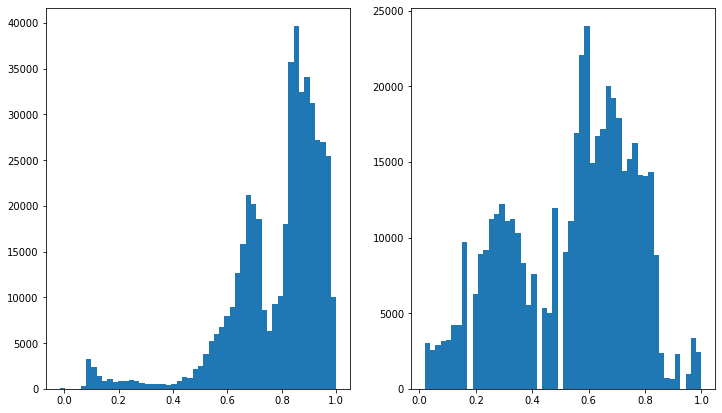

In [5]:
fig,axs = plt.subplots(1,2,figsize=(12,7))

_ = axs[0].hist(MetaData['outbreaktime'],bins=52)
_ = axs[1].hist(MetaData['week'],bins=52)

## Final Dataset

One way to eliminate the imbalance or bias in the data set is to resample it to have evenly distributed samples aiming to have a squared distribution. This reduces the number of samples but removes biases. 

In [6]:
reSamplingIndex = GetEqualizedIndex(MetaData['outbreaktime'],bins=100,maxCount=2000)

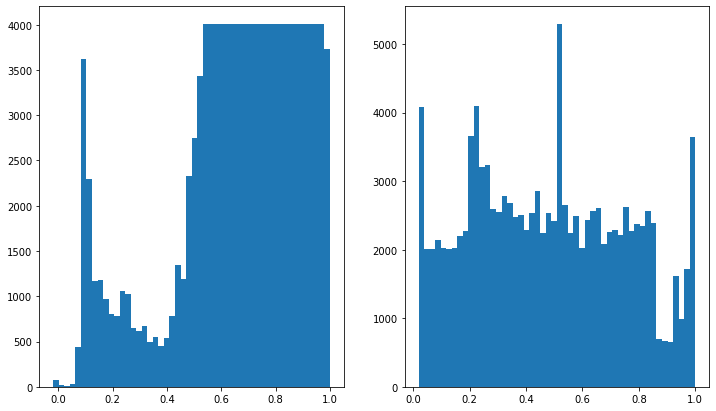

In [7]:
fig,axs = plt.subplots(1,2,figsize=(12,7))

_ = axs[0].hist(MetaData['outbreaktime'].iloc[reSamplingIndex],bins=50)
_ = axs[1].hist(MetaData['week'].iloc[reSamplingIndex],bins=50)

In [8]:
Alphabet = ['A','C','T','G']
KmerLabels = []

maxSize = 5
for k in range(1,maxSize):
    
    KmerLabels.append([''.join(i) for i in product(Alphabet, repeat = k)])
    
KmerLabels = [item for sublist in KmerLabels for item in sublist]
headers = ['id'] + KmerLabels

KmerData = pd.read_csv('../input/covid19-sequences-extended/KmerDataExt.csv',usecols = headers)
KmerData['id'] = [val[0:-2] for val in KmerData['id']]
KmerData = KmerData.set_index('id')

The resampled metadata is used to select the appropriate sequences from the K-mer dataset. The resulting K-mer dataset is divided into two, a training data set for k fold cross-validation. And a test data set for downstream analysis and visualization. 

In [9]:
USIndex = MetaData['id'].iloc[reSamplingIndex]
USKmer = KmerData.loc[USIndex.tolist()]

Index = USKmer.index.tolist()
trainIndex,testIndex,_,_ = train_test_split(Index,Index,test_size=0.10,train_size=0.90,random_state=23)

In [10]:
USKmer

A         C         T         G        AA        AC  \
id                                                                     
OK607277  0.298720  0.183290  0.321766  0.196224  0.095582  0.067462   
OK177035  0.299357  0.183119  0.321438  0.196086  0.096408  0.067422   
OK196184  0.298451  0.183122  0.322001  0.196426  0.095414  0.067260   
MZ555083  0.298682  0.183292  0.321618  0.196408  0.095520  0.067537   
MZ536329  0.298720  0.183464  0.321624  0.196192  0.095416  0.067775   
...            ...       ...       ...       ...       ...       ...   
MW766871  0.298523  0.183547  0.321693  0.196237  0.095329  0.067604   
MZ245558  0.298623  0.183698  0.321346  0.196333  0.095391  0.067706   
OK654202  0.298626  0.183551  0.321541  0.196281  0.095450  0.067576   
MZ433885  0.298575  0.183677  0.321468  0.196280  0.095297  0.067677   
MW306415  0.298576  0.183850  0.321360  0.196214  0.095366  0.067755   

                AT        AG        CA        CC  ...      GGCT      GGCG  \
id                                                ...                       
OK607277  0.077507  0.058122  0.069511  0.029397  ...  0.003125  0.000571   
OK177035  0.077341  0.058140  0.069399  0.029422  ...  0.003117  0.000570   
OK196184  0.077675  0.058055  0.069310  0.029330  ...  0.003192  0.000571   
MZ555083  0.077391  0.058186  0.069555  0.029463  ...  0.003128  0.000572   
MZ536329  0.077380  0.058170  0.069589  0.029387  ...  0.003124  0.000638   
...            ...       ...       ...       ...  ...       ...       ...   
MW766871  0.077382  0.058195  0.069613  0.029600  ...  0.003114  0.000636   
MZ245558  0.077292  0.058254  0.069750  0.029697  ...  0.003117  0.000637   
OK654202  0.077359  0.058228  0.069653  0.029717  ...  0.003150  0.000670   
MZ433885  0.077297  0.058291  0.069721  0.029598  ...  0.003118  0.000637   
MW306415  0.077271  0.058205  0.069832  0.029722  ...  0.003117  0.000637   

              GGTA      GGTC      GGTT      GGTG      GGGA      GGGC  \
id                                                                     
OK607277  0.004065  0.000974  0.004872  0.005208  0.001075  0.001042   
OK177035  0.004055  0.000972  0.004859  0.005261  0.001106  0.001039   
OK196184  0.004065  0.000974  0.004872  0.005275  0.001109  0.001042   
MZ555083  0.004070  0.000975  0.004877  0.005281  0.001110  0.001043   
MZ536329  0.004030  0.000974  0.004904  0.005307  0.001041  0.001008   
...            ...       ...       ...       ...       ...       ...   
MW766871  0.004052  0.000971  0.004922  0.005257  0.001105  0.001038   
MZ245558  0.004056  0.000972  0.004927  0.005330  0.001106  0.001039   
OK654202  0.004054  0.000972  0.004959  0.005260  0.001106  0.001039   
MZ433885  0.004023  0.000972  0.004894  0.005297  0.001106  0.001039   
MW306415  0.004021  0.000972  0.004893  0.005295  0.001072  0.001039   

              GGGT      GGGG  
id                            
OK607277  0.001814  0.000504  
OK177035  0.001843  0.000469  
OK196184  0.001882  0.000470  
MZ555083  0.001850  0.000471  
MZ536329  0.001881  0.000470  
...            ...       ...  
MW766871  0.001875  0.000502  
MZ245558  0.001877  0.000503  
OK654202  0.001843  0.000503  
MZ433885  0.001877  0.000503  
MW306415  0.001877  0.000503  

[121050 rows x 340 columns]

# Network 

The final dataset consisting of K-mer frequencies of the sampled sequences is used to train a variational autoencoder. The model architecture consists of fully connected dense layers with a variational layer in the middle, KL divergence loss is scaled by a factor named shrinkage.

## Definition

In [11]:
def MakeDenseCoder(InputShape,Units,Latent,UpSampling=False):
    '''
    Parameters
    ----------
    InputShape : tuple
        Data shape.
    Units : list
        List with the number of dense units per layer.
    Latent : int
        Size of the latent space.
    UpSampling : bool, optional
        Controls the behaviour of the function, False returns the encoder while True returns the decoder. 
        The default is False.

    Returns
    -------
    InputFunction : Keras Model input function
        Input Used to create the coder.
    localCoder : Keras Model Object
        Keras model.

    '''
    Units.append(Latent)
    
    if UpSampling:
        denseUnits=Units[::-1]
        Name="Decoder"
    else:
        denseUnits=Units
        Name="Encoder"
    
    InputFunction=Input(shape=InputShape)
    nUnits=len(denseUnits)
    X=Dense(denseUnits[0],use_bias=False)(InputFunction)
    X=BatchNormalization()(X)
    X=Activation('relu')(X)
    
    for k in range(1,nUnits-1):
        X=Dense(denseUnits[k],use_bias=False)(X)
        X=BatchNormalization()(X)
        X=Activation('relu')(X)
    
    X=Dense(denseUnits[-1],use_bias=False)(X)
    X=BatchNormalization()(X)
    
    if UpSampling:
        Output=Activation('sigmoid')(X)
        localCoder=Model(inputs=InputFunction,outputs=Output,name=Name)
    else:    
        Output=Activation('relu')(X)
        localCoder=Model(inputs=InputFunction,outputs=Output,name=Name)
    
    return InputFunction,localCoder

class KLDivergenceLayer(Layer):
    '''
    Custom KL loss layer
    '''
    def __init__(self,*args,**kwargs):
        self.annealing = tf.Variable(0.,dtype=tf.float32,trainable = False)
        self.is_placeholder=True
        super(KLDivergenceLayer,self).__init__(*args,**kwargs)
        
    def call(self,inputs):
        
        Mu,LogSigma=inputs
        klbatch=-0.5*self.annealing*K.sum(1+LogSigma-K.square(Mu)-K.exp(LogSigma),axis=-1)
        self.add_loss(K.mean(klbatch),inputs=inputs)
        self.add_metric(klbatch,name='kl_loss',aggregation='mean')
        
        return inputs

class Sampling(Layer):
    '''
    Custom sampling layer
    '''
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def get_config(self):
        config = {}
        base_config = super().get_config()
        return {**base_config, **config}
    
    @tf.autograph.experimental.do_not_convert   
    def call(self,inputs,**kwargs):
        
        Mu,LogSigma=inputs
        batch=tf.shape(Mu)[0]
        dim=tf.shape(Mu)[1]
        epsilon=K.random_normal(shape=(batch,dim))

        return Mu+(K.exp(0.5*LogSigma))*epsilon

#Wrapper function, creates a small Functional keras model 
#Bottleneck of the variational autoencoder 
def MakeVariationalNetwork(Latent):
    
    InputFunction=Input(shape=(Latent,))
    Mu=Dense(Latent)(InputFunction)
    LogSigma=Dense(Latent)(InputFunction)
    Mu,LogSigma=KLDivergenceLayer()([Mu,LogSigma])
    Output=Sampling()([Mu,LogSigma])
    variationalBottleneck=Model(inputs=InputFunction,outputs=Output)
    
    return InputFunction,variationalBottleneck

def MakeDenseAutoencoder(InputShape,Units,Latent):
    
    InputEncoder,Encoder=MakeDenseCoder(InputShape,Units,Latent)
    InputDecoder,Decoder=MakeDenseCoder((Latent,),Units,Latent,UpSampling=True)
    AEoutput=Decoder(Encoder(InputEncoder))
    AE=Model(inputs=InputEncoder,outputs=AEoutput)
    
    return Encoder,Decoder,AE


def MakeVariationalDenseAutoencoder(InputShape,Units,Latent):
    
    InputEncoder,Encoder=MakeDenseCoder(InputShape,Units,Latent)
    InputVAE,VAE=MakeVariationalNetwork(Latent)
    InputDecoder,Decoder=MakeDenseCoder((Latent,),Units,Latent,UpSampling=True)
    
    VAEencoderOutput=VAE(Encoder(InputEncoder))
    VAEencoder=Model(inputs=InputEncoder,outputs=VAEencoderOutput)
    
    VAEOutput=Decoder(VAEencoder(InputEncoder))
    VAEAE=Model(inputs=InputEncoder,outputs=VAEOutput)
    
    return VAEencoder,Decoder,VAEAE

## Auxiliary functions

In [12]:
class KLAnnealing(keras.callbacks.Callback):

    def __init__(self,position, weigths):
        super().__init__()
        self.position = position
        self.weigths = tf.Variable(weigths,trainable=False,dtype=tf.float32)

    def on_epoch_end(self, epoch,logs=None):
        
        weights = self.model.get_weights()
        weights[self.position] = self.weigths[epoch]
        self.model.set_weights(weights)


def MakeAnnealingWeights(epochs,cycles,scale=1):
    
    pointspercycle = epochs//cycles
    AnnealingWeights = 1*(1/(1+np.exp(-1*np.linspace(-10,10,num=pointspercycle))))
    
    for k in range(cycles-1):
        AnnealingWeights = np.append(AnnealingWeights,1*(1/(1+np.exp(-1*np.linspace(-10,10,num=pointspercycle+1)))))
        
    return scale*AnnealingWeights


# Training

In [13]:
Units = [340,240,140,40,20,10,5,3]
Latent = 2

sh = 0.0001#0.00001
lr = 0.0025
minlr = 0.00001
batchSize = 64
epochs = 100
decay = 3*(lr-minlr)/epochs

AnnealingWeights = sh*np.ones(epochs+1)


## K fold cross validation

In [14]:
ModelsContainer = []
HistoryContainer = []
Scalers = []

kf = KFold(n_splits=5,shuffle=True,random_state=44)
XtrainDS = USKmer[KmerLabels].loc[trainIndex]

for train_index, test_index in kf.split(trainIndex):
    
    trainLabels,testLabels = np.array(trainIndex)[train_index],np.array(trainIndex)[test_index]
    Xtrain, Xtest = XtrainDS.loc[trainLabels], XtrainDS.loc[testLabels]
    
    scaler = pr.MinMaxScaler()
    scaler.fit(Xtrain)
    
    Xtrain = scaler.transform(Xtrain)
    Xtest = scaler.transform(Xtest)
    
    Scalers.append(scaler)

    InputShape = Xtrain.shape[1]
    VAEENC,VAEDEC,VAEAE = MakeVariationalDenseAutoencoder(InputShape,Units,Latent)
    KLAposition = [k for k,val in enumerate(VAEAE.get_weights()) if len(val.shape)==0][0]

    VAEAE.compile(Adam(learning_rate=lr,decay=decay),loss='mse')
    history = VAEAE.fit(x=Xtrain,y=Xtrain,batch_size=batchSize,epochs=epochs,
                        validation_data=(Xtest,Xtest),callbacks=[KLAnnealing(KLAposition,AnnealingWeights)])
    
    ModelsContainer.append(VAEENC)
    HistoryContainer.append(history)

    tf.compat.v1.set_random_seed(globalSeed)



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/100
1362/1362 [==============================] - 30s 18ms/step - loss: 0.0144 - kl_loss: 0.0000e+00 - val_loss: 0.0081 - val_kl_loss: 0.0000e+00
Epoch 2/100
1362/1362 [==============================] - 25s 18ms/step - loss: 0.0077 - kl_loss: 7.1215e-05 - val_loss: 0.0083 - val_kl_loss: 2.1770e-04
Epoch 3/100
1362/1362 [==============================] - 23s 17ms/step - loss: 0.0066 - kl_loss: 7.1904e-05 - val_loss: 0.0063 - val_kl_loss: 5.2125e-05
Epoch 4/100
1362/1362 [==============================] - 23s 17ms/step - loss: 0.0056 - kl_loss: 1.4639e-04 - val_loss: 0.0055 - val_kl_loss: 1.7279e-04
Epoch 5/100
1362/1362 [==============================] - 23s 17ms/step - loss: 0.0054 - kl_loss: 1.7742e-04 - val_loss: 0.0054 - val_kl_loss: 1.9204e-04
Epoch 6/100
1362/1362 [==============================] - 23s 17ms/step - loss: 0.0052 - kl_loss: 1.8858e-04 - val_loss: 0.0050 - val_kl_loss: 2.0692e-04
Epoch 7/100
1362/1362 [==============================] - 23s 17ms/step - loss: 0.0

# Bottleneck representation

Bottleneck representation, color encode isolation week regardless of the year. This results into a clear separation into two seasons 

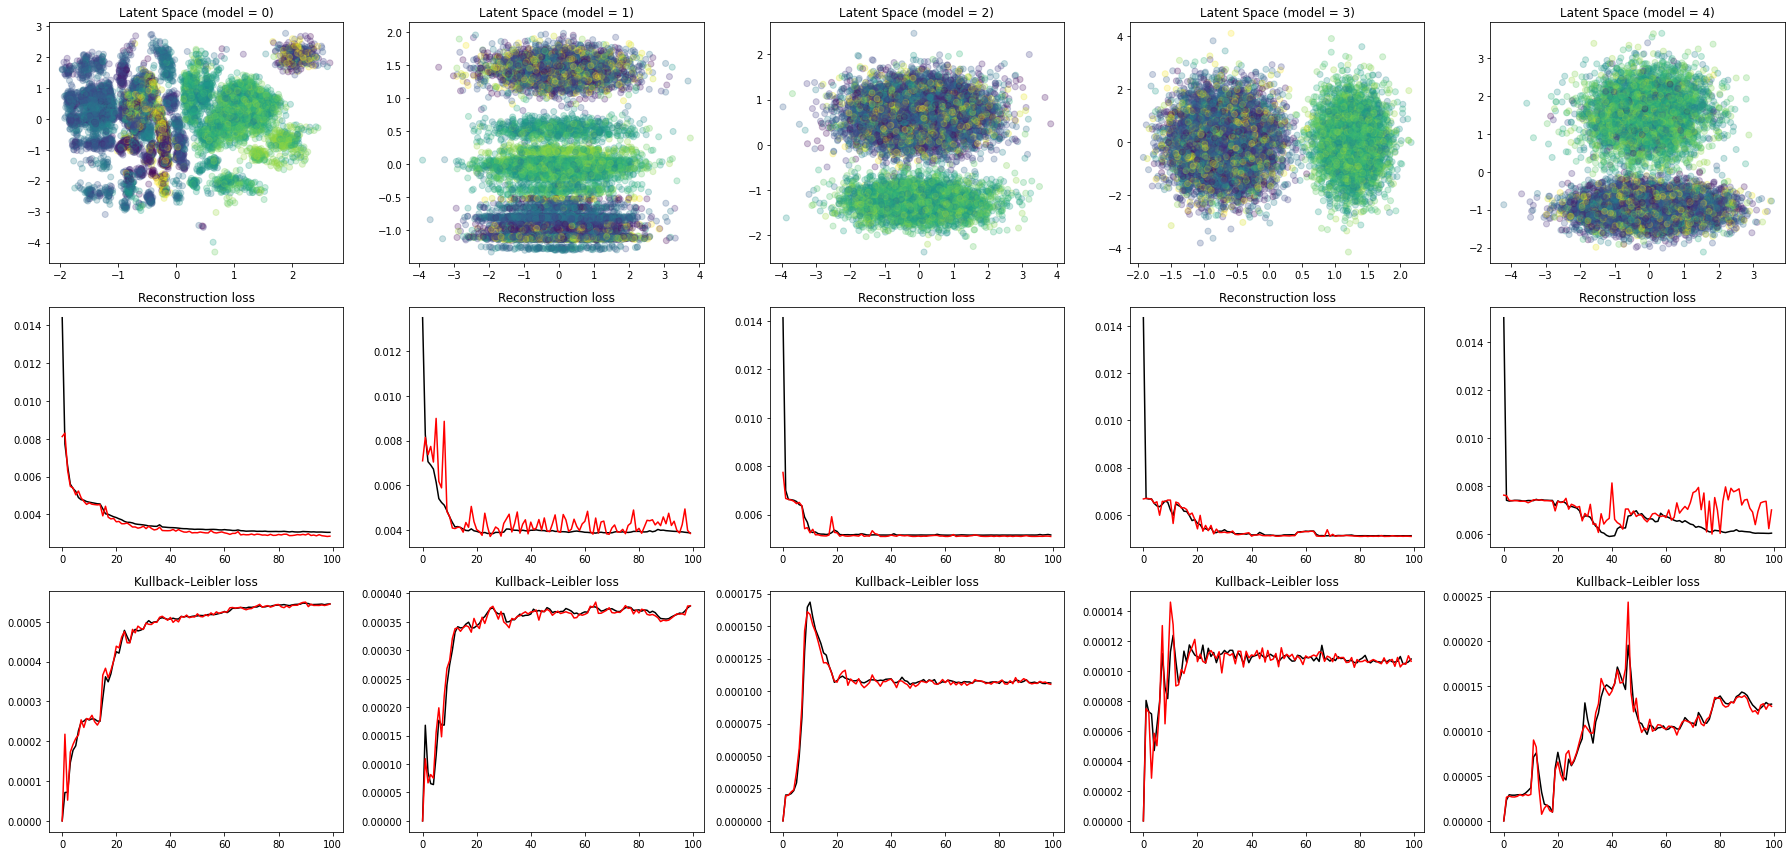

In [15]:
XtestDS = USKmer[KmerLabels].loc[testIndex]
MetaData = MetaData.set_index('id')

fig,axs = plt.subplots(3,5,figsize=(25,12))

for k,block in enumerate(zip(ModelsContainer,HistoryContainer,Scalers)):
    
    mod,hist,scaler = block
    VariationalRepresentation = mod.predict(scaler.transform(XtestDS))
    axs[0,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=MetaData.loc[XtestDS.index.tolist()]['week'],alpha=0.25)
    axs[0,k].title.set_text('Latent Space (model = ' + str(k) +')')
    
    axs[1,k].plot(hist.history['loss'],'k-',label = 'Loss')
    axs[1,k].plot(hist.history['val_loss'],'r-',label = 'Validation Loss')
    axs[1,k].title.set_text('Reconstruction loss')
    
    axs[2,k].plot(hist.history['kl_loss'],'k-',label = 'Loss')
    axs[2,k].plot(hist.history['val_kl_loss'],'r-',label = 'Validation Loss')
    axs[2,k].title.set_text('Kullback–Leibler loss')
    
plt.tight_layout()
    

## Nucleotide content

Small clusters of high Adenine content can be found in two of the models, while small differences in the content in Cytosine are observed between the two main clusters. 

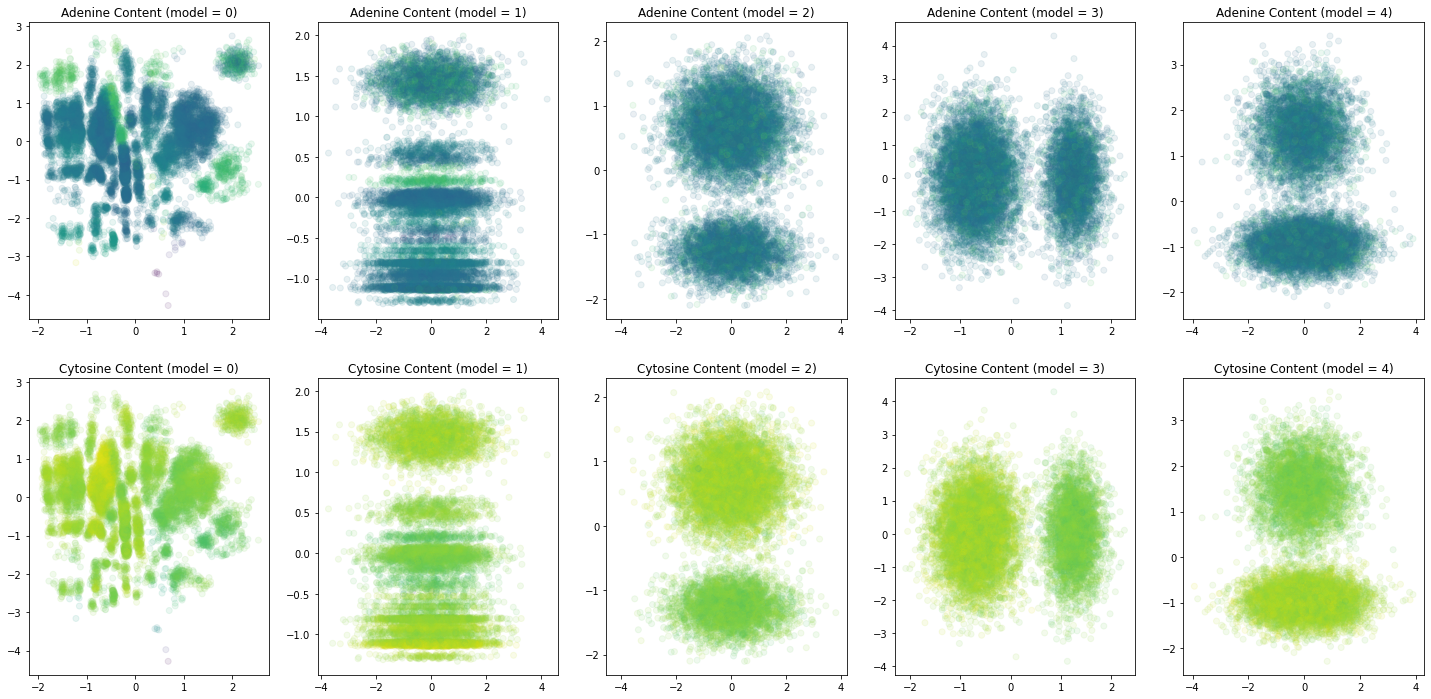

In [16]:
fig,axs = plt.subplots(2,5,figsize=(25,12))

for k,block in enumerate(zip(ModelsContainer,Scalers)):
    
    mod,scaler = block
    VariationalRepresentation = mod.predict(scaler.transform(XtestDS))
    axs[0,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=XtestDS['A'],alpha=0.1)
    axs[0,k].title.set_text('Adenine Content (model = ' + str(k) +')')
    
    axs[1,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=XtestDS['C'],alpha=0.1)
    axs[1,k].title.set_text('Cytosine Content (model = ' + str(k) +')')

Two models show small clusters with different guanine content, while the remaining models do not show any particular difference. While Thymine/Uracil show a small difference between the two main clusters. 

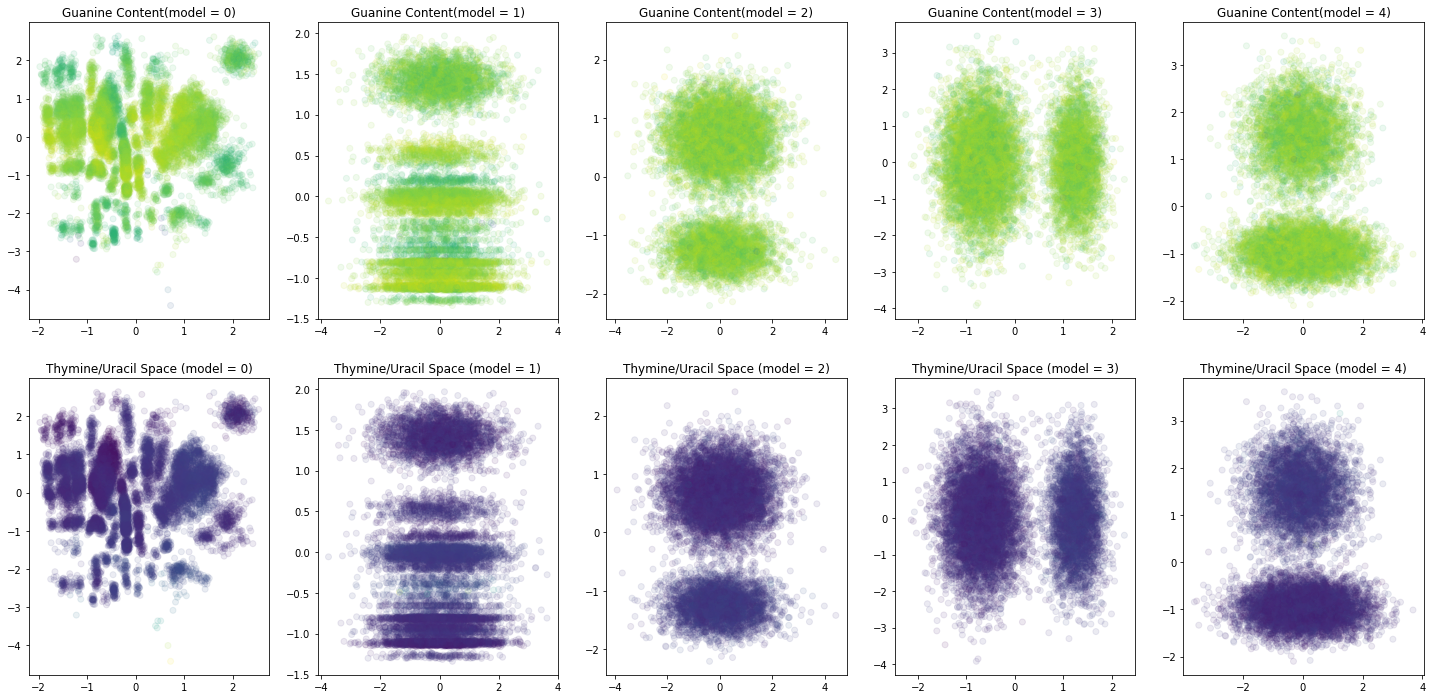

In [17]:
fig,axs = plt.subplots(2,5,figsize=(25,12))

for k,block in enumerate(zip(ModelsContainer,Scalers)):
    
    mod,scaler = block
    VariationalRepresentation = mod.predict(scaler.transform(XtestDS))
    axs[0,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=XtestDS['G'],alpha=0.1)
    axs[0,k].title.set_text('Guanine Content(model = ' + str(k) +')')
    
    axs[1,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=XtestDS['T'],alpha=0.1)
    axs[1,k].title.set_text('Thymine/Uracil Space (model = ' + str(k) +')')
    

# Adding infection dynamics

A small sequence representation allows to visually represent or encode other pandemic characteristics. Thus it will be helpful if the resulting clusters encode information about the pandemic dynamics. From the number of accumulated cases, we can calculate the COVID-19 spread rate or the COVID-19 acceleration spread. Those two numerical features will help to find specific patterns if they exist. 

In [18]:
USAInfectionData = pd.read_csv('../input/us-covid19-dataset-live-hourlydaily-updates/States.csv')
USAInfectionData["datets"] = pd.to_datetime(USAInfectionData['date'],format='%Y-%m-%d')
USAInfectionData["year"] = USAInfectionData["datets"].dt.year
USAInfectionData["week"] = USAInfectionData["datets"].dt.isocalendar().week
USAInfection2021 = USAInfectionData[USAInfectionData["year"]==2021]

In [19]:
USATotal2021 = np.array(USAInfectionData[USAInfectionData["year"]==2021].groupby('week')['cases'].sum()/USAInfectionData[USAInfectionData["year"]==2021].groupby('week')['cases'].sum().max()).reshape((-1,))

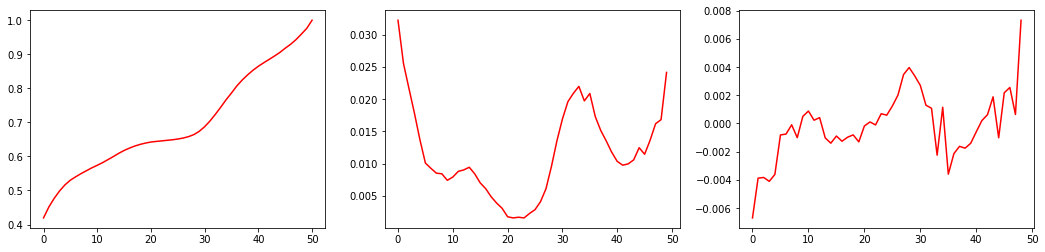

In [20]:
speed = np.diff(USATotal2021[0:-2])
acceleration = np.diff(USATotal2021[0:-2],n=2)

fig,axes = plt.subplots(1,3,figsize=(18,4))

axes[0].plot(USATotal2021[0:-2],color='red')
axes[1].plot(speed,color='red')
axes[2].plot(acceleration,color='red')

In [21]:
speed = np.append(speed,[speed[-1],speed[-1],speed[-1]])
acceleration = np.append(acceleration,[acceleration[-1],acceleration[-1],acceleration[-1],acceleration[-1]])
weeks = np.sort(MetaData['week'].unique())


toSpeed = dict([(val,sal) for val,sal in zip(weeks,speed) ])
toAcceleration = dict([(val,sal) for val,sal in zip(weeks,acceleration)])

In [22]:
MetaData['speed'] = [toSpeed[val] for val in MetaData['week']]
MetaData['acceleration'] = [toAcceleration[val] for val in MetaData['week']]

## Speed and acceleration

Most of the models show a clear speed rate difference between the different clusters. Low and high-speed rates cluster together matching the clusters that contain the sequences isolated at the beginning and the end of the year. However, two particular models start to separate and cluster sequences that were isolated at similar speed rates. While acceleration does not show any particular pattern yet, there are a few isolated glimpses in two models that suggest a particular pattern regarding speed or acceleration. 

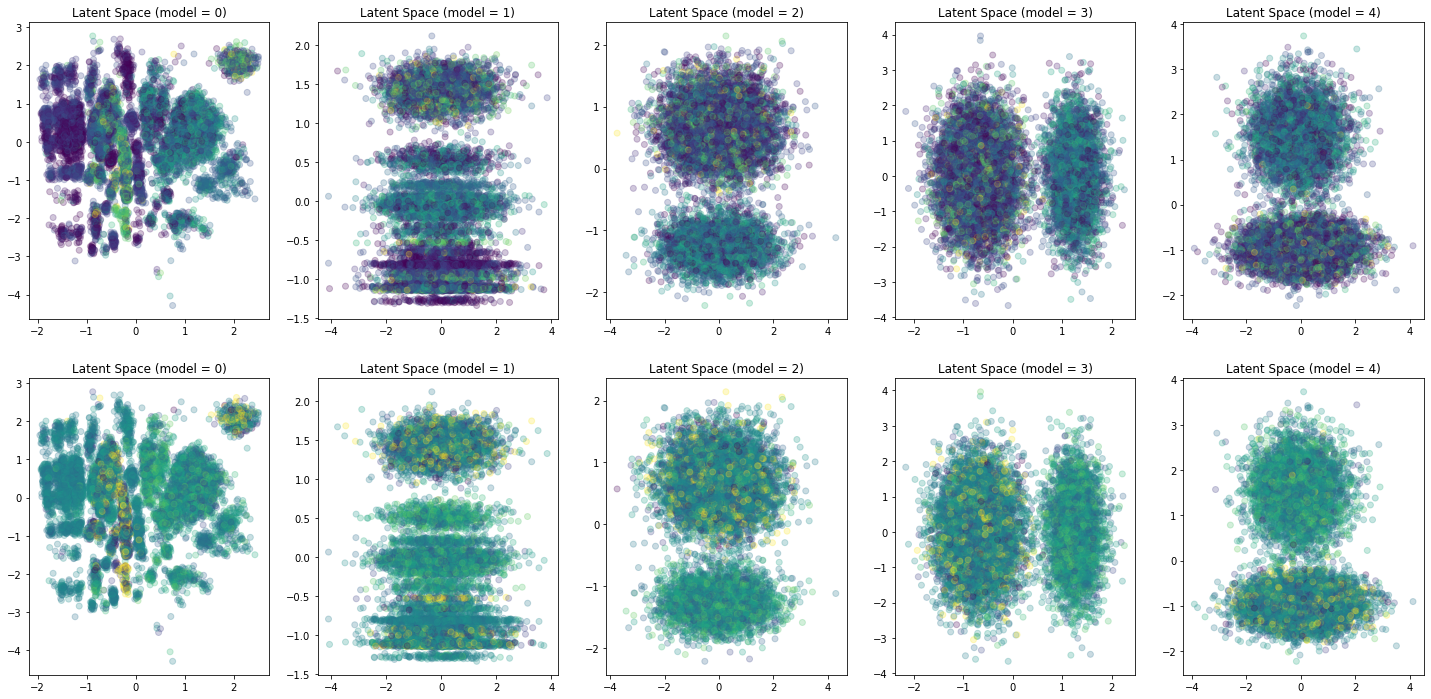

In [23]:
fig,axs = plt.subplots(2,5,figsize=(25,12))

for k,block in enumerate(zip(ModelsContainer,Scalers)):
    
    mod,scaler = block
    VariationalRepresentation = mod.predict(scaler.transform(XtestDS))
    axs[0,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=MetaData.loc[XtestDS.index.tolist()]['speed'],alpha=0.25)
    axs[0,k].title.set_text('Latent Space (model = ' + str(k) +')')
    
    axs[1,k].scatter(VariationalRepresentation[:,0],VariationalRepresentation[:,1],c=MetaData.loc[XtestDS.index.tolist()]['acceleration'],alpha=0.25)
    axs[1,k].title.set_text('Latent Space (model = ' + str(k) +')')

Although the bottleneck representation is different in each model, the most easily recognizable pattern is the clear division into two particular seasons or periods. Thus seasonal information is encoded in the different sequences and k-mer based representations can cluster together sequences containing such patterns. Also, small glimpses of other kinds of patterns start to appear, showing the capabilities and possible applications of autoencoders to SARS-Cov-2 viral dynamics. 

However, specific sequence patterns cannot be found yet, but the resulting clusters will simplify the identification of such patterns. Continuous development of generative models could lead to new insights into SARS-Cov-2 dynamics and evolution or the proposal of new containment measures. 